# Fitting Overtones in GW150914

This cell must be executed first in order for Stan's multiprocessing code to not crash my apple laptop; on linux it's not needed.

In [1]:
import multiprocessing
multiprocessing.set_start_method("fork")

In [2]:
%pylab inline
%config InlineBackend.figure_format = 'png'

Populating the interactive namespace from numpy and matplotlib


In [3]:
import arviz as az
import copy 
import h5py
import gwtones
import pandas as pd
import seaborn as sns

sns.set_context('notebook')
sns.set_palette('colorblind')

Let's download the data for GW150914, found [here](https://www.gw-openscience.org/eventapi/html/GWTC-1-confident/GW150914/v3/).  We grab 32s of data in each IFO, sampled at 16 kHz.

In [4]:
#!wget https://www.gw-openscience.org/eventapi/html/GWTC-1-confident/GW150914/v3/H-H1_GWOSC_4KHZ_R1-1126259447-32.hdf5
#!wget https://www.gw-openscience.org/eventapi/html/GWTC-1-confident/GW150914/v3/L-L1_GWOSC_4KHZ_R1-1126259447-32.hdf5

If you grab the data, the MD5 sums should be:
```
MD5(H-H1_GWOSC_4KHZ_R1-1126259447-32.hdf5)= a78446e549e27632b50ddee5c93d1228
MD5(L-L1_GWOSC_4KHZ_R1-1126259447-32.hdf5)= 49bc64713a612a77903dc3d8b1800805
```

In [5]:
!openssl md5 H-H1_GWOSC_4KHZ_R1-1126259447-32.hdf5
!openssl md5 L-L1_GWOSC_4KHZ_R1-1126259447-32.hdf5

MD5(H-H1_GWOSC_4KHZ_R1-1126259447-32.hdf5)= a78446e549e27632b50ddee5c93d1228
MD5(L-L1_GWOSC_4KHZ_R1-1126259447-32.hdf5)= 49bc64713a612a77903dc3d8b1800805


Now we make timeseries data objects out of the stored data:

In [6]:
def read_strain(file, dname):
    with h5py.File(file, 'r') as f:
        t0 = f['meta/GPSstart'][()]
        T = f['meta/Duration'][()]
        h = f['strain/Strain'][:]
    
        dt = T/len(h)
    
        raw_strain = gwtones.Data(h, index=t0 + dt*arange(len(h)), ifo=dname)
        
        return raw_strain
    
h_raw_strain = read_strain('H-H1_GWOSC_4KHZ_R1-1126259447-32.hdf5', 'H1')
l_raw_strain = read_strain('L-L1_GWOSC_4KHZ_R1-1126259447-32.hdf5', 'L1')

Just a sanity-check plot of the raw strain (just look at the huuuuuge DC noise in LIGO):

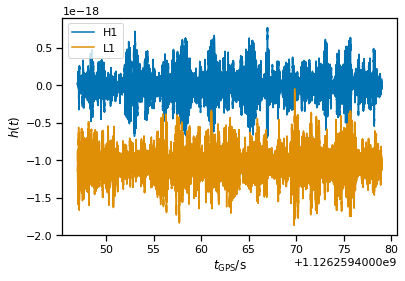

In [7]:
h_raw_strain.plot(label=h_raw_strain.ifo)
l_raw_strain.plot(label=l_raw_strain.ifo)
xlabel(r'$t_\mathrm{GPS} / \mathrm{s}$')
ylabel(r'$h(t)$')
legend(loc='best')

Now that we've got the strain loaded up, we want to condition it a bit.  LIGO does not have very good high-frequency sensitivity; also, our modes do not have a lot of high-frequency content.  Additionally, LIGO contains a lot of low-frequency noise and our templates do not have a lot of power at low frequencies.  Here are estimated noise PSDs for our data:

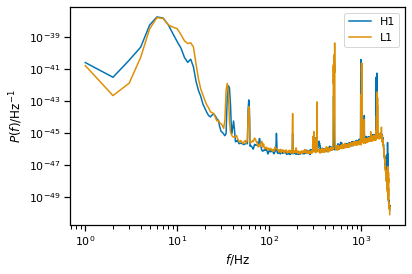

In [8]:
h_raw_strain.get_psd(nperseg=int(h_raw_strain.fsamp)).iloc[1:].plot(label=h_raw_strain.ifo)
l_raw_strain.get_psd(nperseg=int(l_raw_strain.fsamp)).iloc[1:].plot(label=l_raw_strain.ifo)
xlabel(r'$f / \mathrm{Hz}$')
ylabel(r'$P\left( f \right) / \mathrm{Hz}^{-1}$')
xscale('log')
yscale('log')
legend(loc='best')

Because the cost of our analysis scales as $N^2$ for a data segment of $N$ samples, and because the noise in LIGO combined with the finite bandwidth of ringdown modes means that the data are uninformative at both very low and very high frequencies, we can bandpass the data, downsample considerably (to eliminate high-frequency content), and truncate to a very short data segment (to eliminate low frequency content).  The `condition` method accomplishes this; anticipating that we will only be analyzing the first two tones of the $(p = 1, s = -2, \ell = 2, m = 2)$ series of modes (prograde, spin-weight 2, angular quantum numbers $(2,2)$ modes), we will downsample to a sample rate of 4096 Hz, and a segment length of $\sim 20\, \mathrm{ms}$.  This is adequate to capture both the decay rate of the second tone (~700 Hz), and also the length of the first tone (time constant ~ 4.3 ms):

In [35]:
M_est = 70.0
chi_est = 0.7

longest_tau = gwtones.qnms.get_ftau(M_est, chi_est, 0, l=2, m=2)[1]
highest_drate = 1/gwtones.qnms.get_ftau(M_est, chi_est, 1, l=2, m=2)[1]
print('The damping rate of the second tone is: {:.1f} Hz'.format(highest_drate))
print('The time constant of the first tone is: {:.1f} ms'.format(1000*longest_tau))

def next_pow_two(x):
    y = 1
    while y < x:
        y = y << 1
    return y

T = 5*longest_tau
srate = 2048 #next_pow_two(4*highest_drate)

print('Segment of {:.1f} ms at sample rate {:.0f}'.format(1000*T, srate))

The damping rate of the second tone is: 708.4 Hz
The time constant of the first tone is: 4.3 ms
Segment of 21.3 ms at sample rate 2048


However, when we downsample, we want to be sure to preserve a sample as close as possible to the ringdown "start time," corresponding to the arrival time of the peak of the complex strain of the (2,2) mode ([Giesler, et al. 2019](https://ui.adsabs.harvard.edu/abs/2019PhRvX...9d1060G/abstract)).  One issue we have to deal with is that the signal arrives in the detectors at different times (the time delay between detectors depends on the source location on the sky).  The `Fit` object knows how to handle this for us.  We take the sky location, polarization, and time of arrival from [Isi, et al. (2019)](https://ui.adsabs.harvard.edu/abs/2019PhRvL.123k1102I/abstract), set the duration to about `0.02`, and condition to 4096 Hz sample rate.

The fit object expects to receive a list of modes; the most explicit way to specify them is to give tuples of `(p, s, l, m, n)`, where `p = +/- 1` indicates prograde/retrograde, `s = -2` is the spin weight, `l` and `m` are the usual angular quantum numbers, and `n` is the tone index.  (The modes are elliptically polarized, so there is no need to specify both + and - `m` quantum numbers; it is assumed that both positive and negative `m` contribute to a mode.)  Because Isi, et al. (2019) found only convincing evidence of two tones, that is the model we fit.

In [36]:
fit = gwtones.Fit(model='mchi', modes=[(1, -2, 2, 2, 0), (1, -2, 2, 2, 1)])  # use model='ftau' to fit damped sinusoids instead of +/x polarized GW modes
fit.add_data(h_raw_strain)
fit.add_data(l_raw_strain)
fit.set_target(1126259462.4083147, ra=1.95, dec=-1.27, psi=0.82, duration=T)
fit.condition_data(ds=int(round(4096/srate)), flow=1/(2*T)) 

Just for a sanity check, let's look at the time of arrival of the peak strain in each IFO (Isi, et al. (2019) actually gives the `H1` start time, not the geocentre time, as `1126259462.423`):

In [37]:
fit.start_times

{'H1': 1126259462.423, 'L1': 1126259462.4160156}

Here you can see that the PSD of the conditioned data only goes up to 2048 Hz (it's been downsampled to a new Nyquist frequency of 2048 Hz), and that the noise power is much smaller below 20 Hz.  The vertical black line marks the frequency that corresponds to $1/T$, aka the "first Fourier" bin for our short segment.

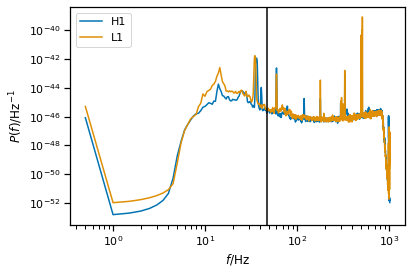

In [38]:
fit.data['H1'].get_psd(nperseg=4096).iloc[1:].plot(label='H1')
fit.data['L1'].get_psd(nperseg=4096).iloc[1:].plot(label='L1')
xscale('log')
yscale('log')
xlabel(r'$f / \mathrm{Hz}$')
ylabel(r'$P(f) / \mathrm{Hz}^{-1}$')
axvline(1/T, color='black')
legend(loc='best')

Before sampling over the posterior on modes, we need to set up some priors with reasonable choices:

In [39]:
print(fit.valid_model_options)

['A_scale', 'perturb_f', 'perturb_tau', 'df_max', 'dtau_max', 'M_min', 'M_max', 'chi_min', 'chi_max']


The `A_max` parameter is not very well-named---it should really be `A_scale`.  We set a reasonable prior on the quadrature amplitudes of `A_max = 5e-21`.  The `flat_A_ellip` option controls whether we place a Gaussian prior on the quadratures (`flat_A_ellip = 0`)---which is much faster to sample because it does not have weird linear structures in the quadratures---or (as in our paper) a flat prior on `A` and `ellip` (`flat_A_ellip > 0`).

In [40]:
fit.update_prior(A_scale=5e-21, M_min=35.0, M_max=140.0)

Here are the priors (with default values for the options we didn't set).  The `perturb` are boolean arrays indicating whether to perturb `f` and `tau` around the GR values; the perturbations (if present) are bounded to a maximum amplitude.

In [41]:
fit.prior_settings

{'A_scale': 5e-21,
 'perturb_f': array([0., 0.]),
 'perturb_tau': array([0., 0.]),
 'df_max': 0.9,
 'dtau_max': 0.9,
 'M_min': 35.0,
 'M_max': 140.0,
 'chi_min': 0,
 'chi_max': 0.99}

Our fit is ready to go; run it!  (The first time the any fit runs in a given session, the `PySTAN` model code is compiled, which can take a while.  Subsequent runs will use the precompiled code and be much quicker.)

(Ignore the warning about computing the ACF with default settings; these are fine.  If you want to play around with the detector noise model, see the options for `fit.compute_acf`.)

In [42]:
fit.run()

Running mchi

Gradient evaluation took 0.000522 seconds
1000 transitions using 10 leapfrog steps per transition would take 5.22 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)

Gradient evaluation took 0.0005 seconds
1000 transitions using 10 leapfrog steps per transition would take 5 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000493 seconds
1000 transitions using 10 leapfrog steps per transition would take 4.93 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)

Gradient evaluation took 0.000554 seconds
1000 transitions using 10 leapfrog steps per transition would take 5.54 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  400 

`fit.result` contains an arviz object giving our results:

In [43]:
az.summary(fit.result, var_names=['A', 'ellip', 'M', 'chi', 'f', 'tau'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
A[0],0.000,0.000,0.000,0.000,0.000,0.000,1209.0,786.0,1.0
A[1],0.000,0.000,0.000,0.000,0.000,0.000,1488.0,1191.0,1.0
ellip[0],0.100,0.580,-0.859,0.999,0.016,0.011,1401.0,1820.0,1.0
ellip[1],-0.078,0.550,-0.992,0.830,0.013,0.010,1777.0,1553.0,1.0
M,83.673,15.759,58.139,113.743,0.546,0.402,949.0,627.0,1.0
chi,0.606,0.253,0.126,0.989,0.008,0.006,846.0,823.0,1.0
f[0],204.492,12.123,182.701,225.761,0.298,0.216,1842.0,1387.0,1.0
f[1],198.833,13.479,174.704,223.015,0.347,0.250,1638.0,1383.0,1.0
tau[0],0.006,0.002,0.003,0.010,0.000,0.000,955.0,760.0,1.0
tau[1],0.002,0.001,0.001,0.003,0.000,0.000,950.0,760.0,1.0


array([[<AxesSubplot:title={'center':'A'}>,
        <AxesSubplot:title={'center':'A'}>],
       [<AxesSubplot:title={'center':'ellip'}>,
        <AxesSubplot:title={'center':'ellip'}>],
       [<AxesSubplot:title={'center':'M'}>,
        <AxesSubplot:title={'center':'M'}>],
       [<AxesSubplot:title={'center':'chi'}>,
        <AxesSubplot:title={'center':'chi'}>],
       [<AxesSubplot:title={'center':'theta'}>,
        <AxesSubplot:title={'center':'theta'}>],
       [<AxesSubplot:title={'center':'f'}>,
        <AxesSubplot:title={'center':'f'}>],
       [<AxesSubplot:title={'center':'tau'}>,
        <AxesSubplot:title={'center':'tau'}>]], dtype=object)

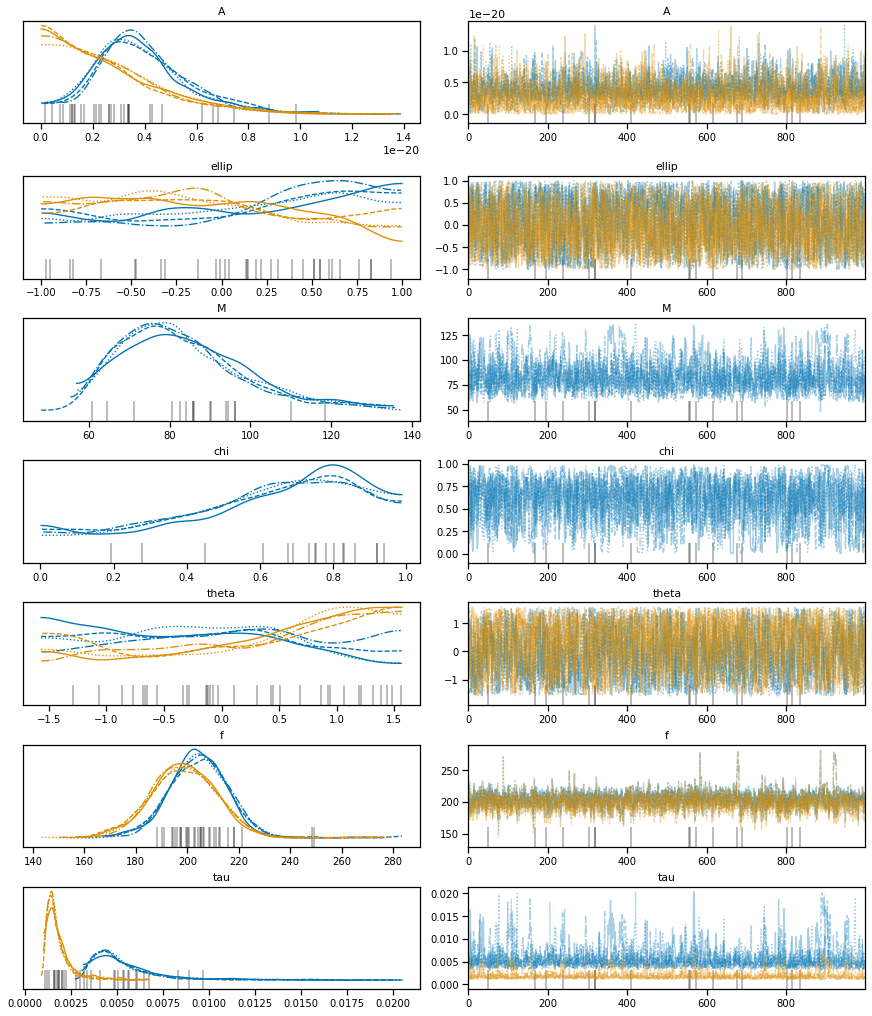

In [44]:
az.plot_trace(fit.result, var_names=['A', 'ellip', 'M', 'chi', 'theta', 'f', 'tau'], compact=True)

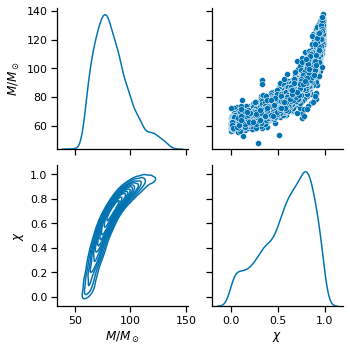

In [45]:
pg = sns.PairGrid(pd.DataFrame({r'$M / M_\odot$': fit.result.posterior.M.values.flatten(),
                                r'$\chi$': fit.result.posterior.chi.values.flatten()}),
                  diag_sharey=False)
pg.map_diag(sns.kdeplot)
pg.map_upper(sns.scatterplot)
pg.map_lower(gwtones.kdeplot_2d_clevels)

Text(0.5, 1.0, '$f_0 = 204^{+11}_{-11} \\, \\mathrm{Hz}$')

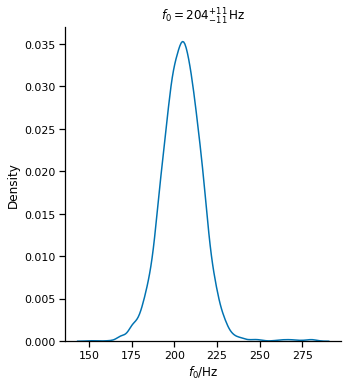

In [46]:
f0 = fit.result.posterior.f.values[:,:,0].flatten()
m = median(f0)
h = quantile(f0, 0.84)
l = quantile(f0, 0.16)
sns.displot(fit.result.posterior.f.values[:,:,0].flatten(), kind='kde')
xlabel(r'$f_0 / \mathrm{Hz}$')
title(r'$f_0 = {:.0f}^{{+{:.0f}}}_{{-{:.0f}}} \, \mathrm{{Hz}}$'.format(m, h-m, m-l))

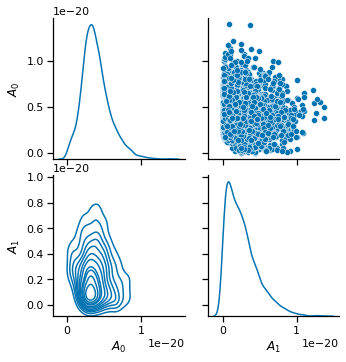

In [47]:
pg = sns.PairGrid(pd.DataFrame({r'$A_0$': fit.result.posterior.A.values[:,:,0].flatten(),
                                r'$A_1$': fit.result.posterior.A.values[:,:,1].flatten()}),
                  diag_sharey=False)
pg.map_diag(sns.kdeplot)
pg.map_upper(sns.scatterplot)
pg.map_lower(gwtones.kdeplot_2d_clevels)

In [48]:
ms = {'H1': fit.result.posterior.h_det.mean(axis=(0,1)).values[0,:], 
      'L1': fit.result.posterior.h_det.mean(axis=(0,1)).values[1,:]}

mf = {'H1': fit.result.posterior.h_det_mode.mean(axis=(0,1)).values[0,0,:],
      'L1': fit.result.posterior.h_det_mode.mean(axis=(0,1)).values[1,0,:]}

mo = {'H1': fit.result.posterior.h_det_mode.mean(axis=(0,1)).values[0,1,:],
      'L1': fit.result.posterior.h_det_mode.mean(axis=(0,1)).values[1,1,:]}

In [49]:
wd = fit.whiten(fit.analysis_data)
ws = fit.whiten(ms)
wf = fit.whiten(mf)
wo = fit.whiten(mo)

In [50]:
ts = [d.time for d in fit.analysis_data.values()]

Text(0, 0.5, '$h(t)$')

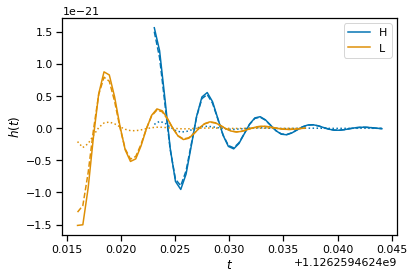

In [51]:
l, = plot(ts[0], ms['H1'], label='H')
plot(ts[0], mf['H1'], ls='--', color=l.get_color())
plot(ts[0], mo['H1'], ls=':', color=l.get_color())

l, = plot(ts[1], ms['L1'], label='L')
plot(ts[1], mf['L1'], ls='--', color=l.get_color())
plot(ts[1], mo['L1'], ls=':', color=l.get_color())

legend(loc='best')
xlabel(r'$t$')
ylabel(r'$h(t)$')

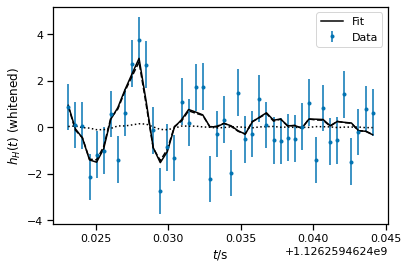

In [52]:
errorbar(ts[0], wd['H1'], yerr=ones_like(wd['H1']), fmt='.', label='Data')
plot(ts[0], ws['H1'], color="black", label='Fit')
plot(ts[0], wf['H1'], color="black", ls='--')
plot(ts[0], wo['H1'], color='black', ls=':')

xlabel(r'$t / \mathrm{s}$')
ylabel(r'$h_H(t)$ (whitened)')
legend(loc='best')

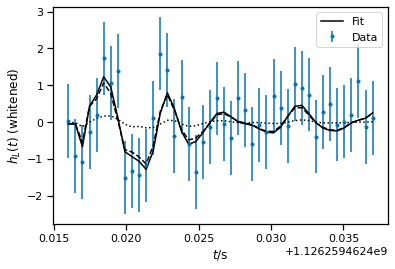

In [53]:
errorbar(ts[1], wd['L1'], yerr=ones_like(wd['L1']), fmt='.', label='Data')
plot(ts[1], ws['L1'], color="black", label='Fit')
plot(ts[1], wf['L1'], color="black", ls='--')
plot(ts[1], wo['L1'], color='black', ls=':')

xlabel(r'$t / \mathrm{s}$')
ylabel(r'$h_L(t)$ (whitened)')
legend(loc='best')

In [54]:
fit.run(prior=True)

Running mchi

Gradient evaluation took 0.000391 seconds
1000 transitions using 10 leapfrog steps per transition would take 3.91 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)

Gradient evaluation took 0.000352 seconds
1000 transitions using 10 leapfrog steps per transition would take 3.52 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)

Gradient evaluation took 0.000464 seconds
1000 transitions using 10 leapfrog steps per transition would take 4.64 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)

Gradient evaluation took 0.000344 seconds
1000 transitions using 10 leapfrog steps per transition would take 3.44 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration: 

array([[<AxesSubplot:title={'center':'M'}>,
        <AxesSubplot:title={'center':'M'}>],
       [<AxesSubplot:title={'center':'chi'}>,
        <AxesSubplot:title={'center':'chi'}>],
       [<AxesSubplot:title={'center':'A'}>,
        <AxesSubplot:title={'center':'A'}>],
       [<AxesSubplot:title={'center':'ellip'}>,
        <AxesSubplot:title={'center':'ellip'}>],
       [<AxesSubplot:title={'center':'theta'}>,
        <AxesSubplot:title={'center':'theta'}>],
       [<AxesSubplot:title={'center':'f'}>,
        <AxesSubplot:title={'center':'f'}>],
       [<AxesSubplot:title={'center':'tau'}>,
        <AxesSubplot:title={'center':'tau'}>]], dtype=object)

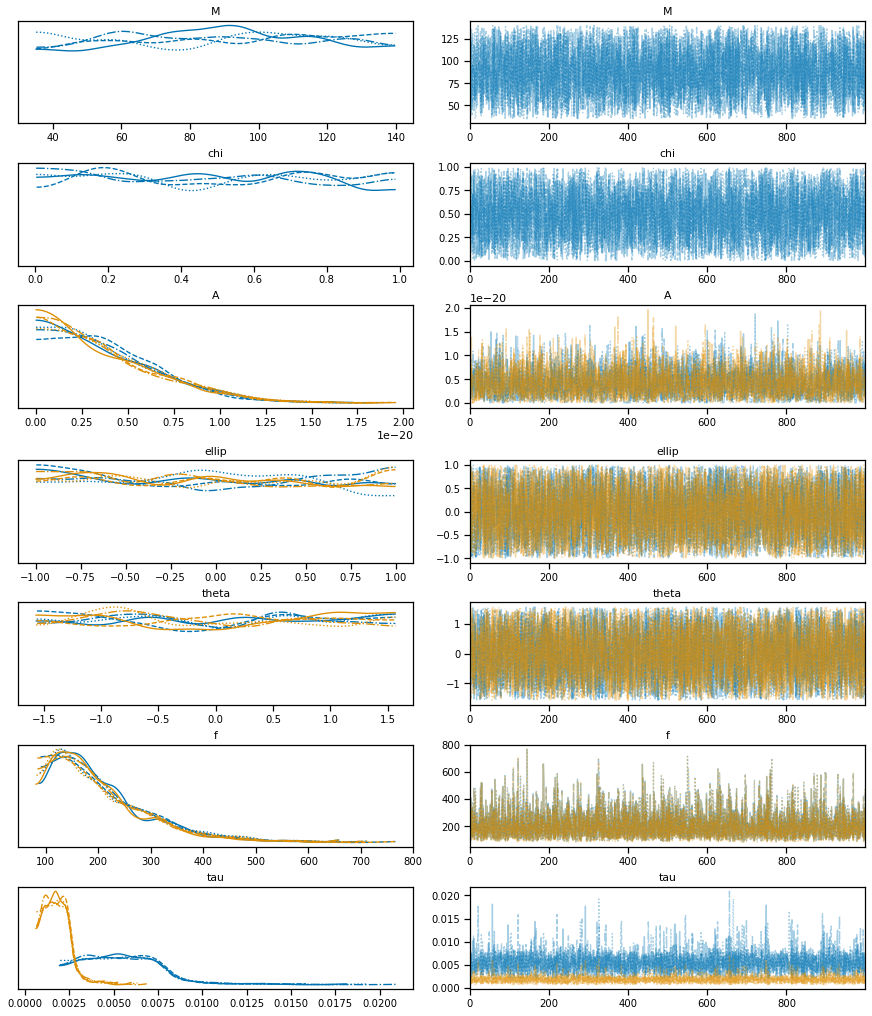

In [56]:
az.plot_trace(fit.prior, var_names=['M', 'chi', 'A', 'ellip', 'theta', 'f', 'tau'])

In [57]:
fit_testgr = copy.copy(fit)

In [58]:
print(fit_testgr.valid_model_options)

['A_scale', 'perturb_f', 'perturb_tau', 'df_max', 'dtau_max', 'M_min', 'M_max', 'chi_min', 'chi_max']


In [59]:
fit_testgr.update_prior(perturb_f = [0, 1], perturb_tau = [0,1])

In [60]:
fit_testgr.run()

Running mchi

Gradient evaluation took 0.000502 seconds
1000 transitions using 10 leapfrog steps per transition would take 5.02 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.0005 seconds
1000 transitions using 10 leapfrog steps per transition would take 5 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000726 seconds
1000 transitions using 10 leapfrog steps per transition would take 7.26 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:    1 / 2000 [  0%]  (Warmup)

Gradient evaluation took 0.000444 seconds
1000 transitions using 10 leapfrog steps per transition would take 4.44 seconds.
Adjust your expectations accordingly!


Iteration:    1 / 2000 [  0%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  200 / 2000 [ 10%]  (Warmup)
Iteration:  400 

array([[<AxesSubplot:title={'center':'M'}>,
        <AxesSubplot:title={'center':'M'}>],
       [<AxesSubplot:title={'center':'chi'}>,
        <AxesSubplot:title={'center':'chi'}>],
       [<AxesSubplot:title={'center':'df'}>,
        <AxesSubplot:title={'center':'df'}>],
       [<AxesSubplot:title={'center':'dtau'}>,
        <AxesSubplot:title={'center':'dtau'}>],
       [<AxesSubplot:title={'center':'f'}>,
        <AxesSubplot:title={'center':'f'}>],
       [<AxesSubplot:title={'center':'tau'}>,
        <AxesSubplot:title={'center':'tau'}>],
       [<AxesSubplot:title={'center':'A'}>,
        <AxesSubplot:title={'center':'A'}>],
       [<AxesSubplot:title={'center':'ellip'}>,
        <AxesSubplot:title={'center':'ellip'}>]], dtype=object)

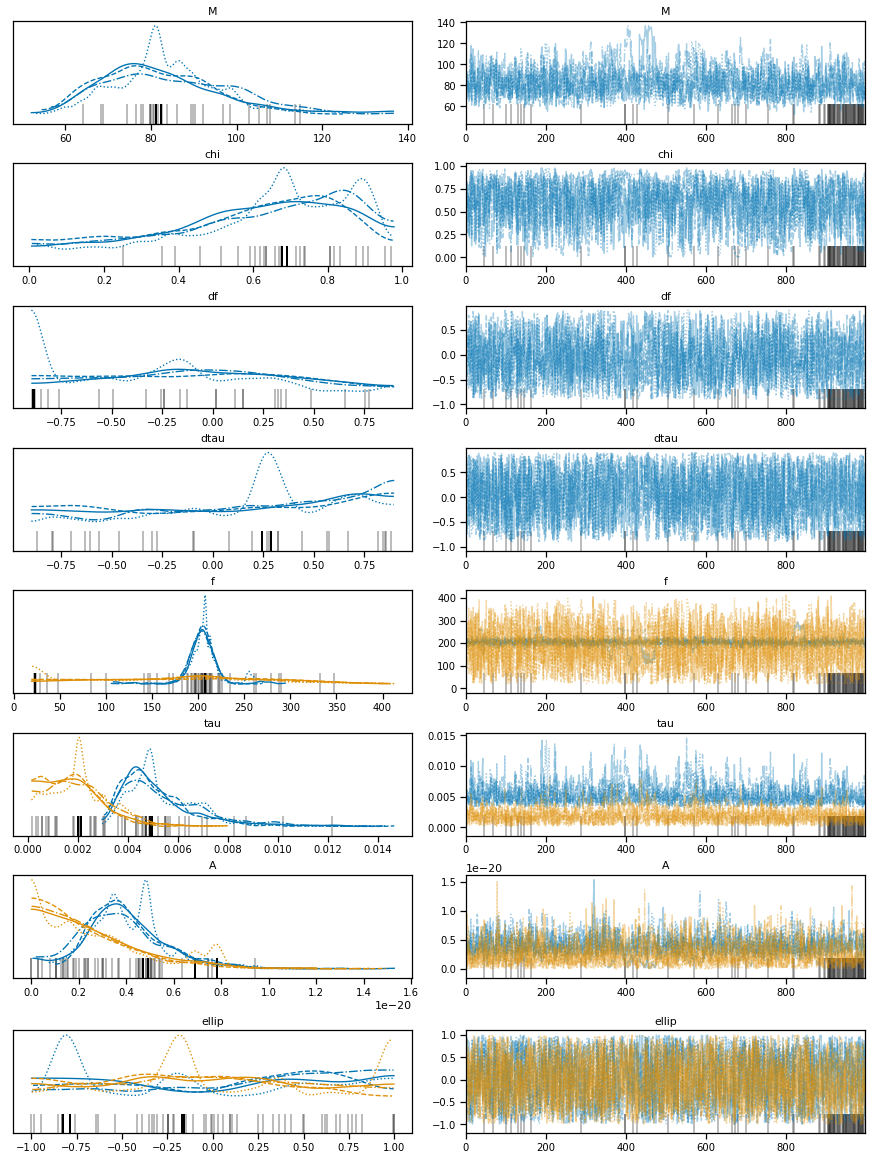

In [61]:
az.plot_trace(fit_testgr.result, var_names=['M', 'chi', 'df', 'dtau', 'f', 'tau', 'A', 'ellip'], coords={'df_dim_0': 1, 'dtau_dim_0': 1})